In [1]:
import numpy as np
from mikeio.dfs0 import Dfs0
from mikeio.eum import TimeStep
from datetime import datetime, timedelta

# Create a timeseries

In [2]:
data = []

nt = 10
d1 = np.zeros(nt)
data.append(d1)
d2 = np.ones(nt)
data.append(d2)

names = ["Zeros", "Ones"]

dfs = Dfs0()


dfs.create(filename="test.dfs0", data=data, names=names, title="Zeros and ones",
           start_time=datetime(2000,1,1),
           timeseries_unit=TimeStep.DAY, dt=7)

# Read a timeseries

In [3]:
res = dfs.read("test.dfs0")

In [4]:
res.names

['Zeros', 'Ones']

In [5]:
res.time

[datetime.datetime(2000, 1, 1, 0, 0),
 datetime.datetime(2000, 1, 8, 0, 0),
 datetime.datetime(2000, 1, 15, 0, 0),
 datetime.datetime(2000, 1, 22, 0, 0),
 datetime.datetime(2000, 1, 29, 0, 0),
 datetime.datetime(2000, 2, 5, 0, 0),
 datetime.datetime(2000, 2, 12, 0, 0),
 datetime.datetime(2000, 2, 19, 0, 0),
 datetime.datetime(2000, 2, 26, 0, 0),
 datetime.datetime(2000, 3, 4, 0, 0)]

In [6]:
res.data

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]

## Or as a Pandas dataframe

In [7]:
df = dfs.read_to_pandas("test.dfs0")
df.head()

,Zeros,Ones
2000-01-01,0.0,1.0
2000-01-08,0.0,1.0
2000-01-15,0.0,1.0
2000-01-22,0.0,1.0
2000-01-29,0.0,1.0


## Create a timeseries with non-equidistant data

In [8]:
data = []

d1 = np.random.uniform(low=0.0, high=5.0, size=5)
data.append(d1)

datetimes = [
    datetime(2000, 1, 1, 0, 0),
    datetime(2000, 1, 8, 0, 0),
    datetime(2000, 1, 10, 0, 0),
    datetime(2000, 2, 22, 0, 0),
    datetime(2000, 11, 29, 0, 0)
]

dfs = Dfs0()


dfs.create(filename="neq.dfs0",
           datetimes=datetimes, 
           data=data,
           title="Non equidistant"
)

## Create a timeseries with accumulated timestep

## Find correct eum units

In [9]:
from mikeio.dfs_util import type_list, unit_list


type_list("Prec")

{100190: 'Correction of precipitation',
 100192: 'Precipitation correction',
 100232: 'Precipitation',
 100233: 'Specific Precipitation',
 100431: 'Precipitation Rate'}

In [10]:
unit_list(100431)

{2004: 'mm/day',
 2001: 'mm/hour',
 2018: 'cm/hour',
 2000: 'meter/sec',
 2006: 'meter/day',
 2009: 'feet/day',
 2016: 'inch/hour',
 2014: 'inch/min',
 4802: 'inch/day',
 2040: 'mm/year'}

In [11]:
from DHI.Generic.MikeZero.DFS import DataValueType
n= 1000
d1 = np.random.random([n])
d2 = np.random.random([n])
data = []
data.append(d1)
data.append(d2)
start_time = datetime(2017, 1, 1)
time_vector = []
t = start_time
random_dt = np.random.choice([1.0,2.0],size=n)
for i in range(n):
    t = t + timedelta(hours=random_dt[i])
    time_vector.append(t)
title = 'Hello Test'
names = ['Water level', 'Precipitation']
variable_type = [100000, 100431]
unit = [1000, 2004]
data_value_type = [DataValueType.Instantaneous, DataValueType.Accumulated]

dfs = Dfs0()
dfs.create(filename='accumulated.dfs0', data=data,
        datetimes=time_vector,
        names=names, title=title,
        variable_type=variable_type, unit=unit,
        data_value_type=data_value_type)

# Modify an existing timeseries

The `write` method allows to modify the data without the need of specifying names, units etc. If you need to add variables, rename, change units, you must use `create` instead.

In [12]:
res = dfs.read("test.dfs0")
res

DataSet(data, time, names)
Number of items: 2
Shape: (10,)
2000-01-01 00:00:00 - 2000-03-04 00:00:00

In [13]:
res['Ones']

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Modify the data in some way...

In [14]:
data = res.data
data[1] = data[1]*np.pi
data[1]

array([3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265,
       3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265])

In [15]:
from shutil import copyfile
copyfile("test.dfs0","modified.dfs0")
dfs.write("modified.dfs0", data)

In [16]:
res = dfs.read("modified.dfs0")
res['Ones']

array([3.14159274, 3.14159274, 3.14159274, 3.14159274, 3.14159274,
       3.14159274, 3.14159274, 3.14159274, 3.14159274, 3.14159274])

The second item is modified.

In [17]:
res['Zeros']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Convert units

Read a file with waterlevel i meters.

In [18]:
dfs = Dfs0()
filename = r"C:\Program Files (x86)\DHI\2020\MIKE Zero\Examples\MIKE_21\FlowModel_FM\HD\Oresund\Data\1993\Boundary_Conditions\waterlevel_viken.dfs0"

ds = dfs.read(filename)
dfs._dfs.ItemInfo[0].Quantity.UnitAbbreviation

'm'

C:\Users\JAN\AppData\Local\Continuum\miniconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


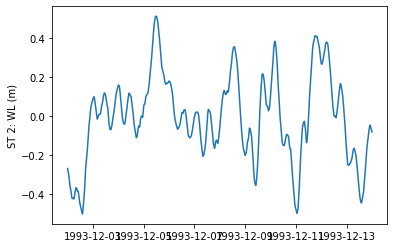

In [19]:
import matplotlib.pyplot as plt
plt.plot(ds.time,ds.data[0])
plt.ylabel(ds.names[0]);

The aim is to convert this timeseries to feet (1m = 3.3 ft)

In [20]:
data = ds.data
data[0] = data[0]*3.3

In [21]:
type_list("Water level")

{100000: 'Water Level', 100307: 'Water level change'}

In [22]:
unit_list(100000)

{1000: 'meter',
 1001: 'kilometer',
 1007: 'centimeter',
 1002: 'millimeter',
 1003: 'feet',
 1014: 'feet US',
 1004: 'inch',
 1013: 'inch US',
 1005: 'mile',
 1016: 'mile US',
 1006: 'yard',
 1015: 'yard US'}

In [23]:
dfs = Dfs0()
dfs.create(filename='wl_feet.dfs0', data=ds.data,
           start_time=ds.time[0],
            dt = 1800,
            names=["Viken"],
            title="Water level",
            variable_type=[100000], unit=[1003])

![WL](../images/wl_feet.png)

## Clean up

In [24]:
import os

os.remove("test.dfs0")
os.remove("modified.dfs0")
os.remove("neq.dfs0")
os.remove("accumulated.dfs0")
os.remove("wl_feet.dfs0")